In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import models, data_reader, utils, train, predict

%matplotlib inline

image_folder = 'data/images/'
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

rust


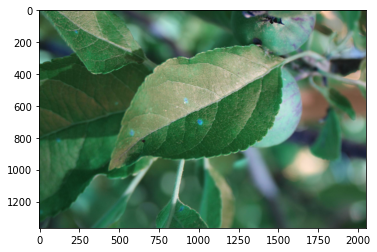

In [2]:
row = train_data.sample(1).iloc[0,:]
for c in row.iteritems():
    if c[1] == 1:
        print(c[0])
img = cv2.imread(f"data/images/{row['image_id']}.jpg")
plt.imshow(img)

In [3]:
train_generator, validation_generator = data_reader.get_generators(32, 320)
model = models.get_model('inception')
callbacks = utils.get_callbacks('inception')
# train the model on the new data for a few epochs
history = model.fit(generator=train_generator,
                   validation_data=validation_generator,
                   epochs=10,
                   shuffle=True,
                   use_multiprocessing=False,
                   verbose=1,
                   callbacks=callbacks)

Found 1639 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 6 steps
Epoch 1/10
52/52 [==============================] - 337s 6s/step - loss: 1.1630 - accuracy: 0.4966 - val_loss: 1.1042 - val_accuracy: 0.5110
Epoch 2/10
52/52 [==============================] - 370s 7s/step - loss: 0.9068 - accuracy: 0.6815 - val_loss: 1.0332 - val_accuracy: 0.5769
Epoch 3/10
52/52 [==============================] - 413s 8s/step - loss: 0.7952 - accuracy: 0.7273 - val_loss: 1.1764 - val_accuracy: 0.4835
Epoch 4/10
52/52 [==============================] - 434s 8s/step - loss: 0.7144 - accuracy: 0.7682 - val_loss: 0.9664 - val_accuracy: 0.6099
Epoch 5/10
52/52 [==============================] - 336s 6s/step - loss: 0.6824 - accuracy: 0.7706 - val_loss: 1.0012 - val_accuracy: 0.6044
Epoch 6

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_generators(batch_size=32, input_size=224, seed=1988):
    image_folder = 'data/images/'
    train_data = pd.read_csv('data/train.csv')
    test_data = pd.read_csv('data/test.csv')
    sample_submission = pd.read_csv('data/sample_submission.csv')

    test_df = test_data.copy()
    test_df['x_col'] = test_df['image_id'].apply(lambda x: f"data/images/{x}.jpg")
    test_df = test_df[['x_col']]
    test_df['y_col'] = 'healthy'

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="x_col",
        y_col="y_col",
        target_size=(input_size, input_size),
        batch_size=batch_size,
        class_mode='categorical')

    return test_generator

In [48]:
name = 'models/inception/weights-04-0.610.hdf5'
model = models.get_model('inception')
model.load_weights(name)

In [58]:
import os
best = 0
for f in os.listdir('models/inception/'):
    if f.endswith('.hdf5'):
        acc = int(f.split('-')[-1].split('.')[1])
        if acc > best:
            best = acc
print([f for f in os.listdir('models/inception/') if f.endswith(f'{best}.hdf5')][0])

weights-01-0.659.hdf5


In [54]:
[f for f in os.listdir('models/inception/') if f.endswith('.hdf5')]

['weights-01-0.401.hdf5',
 'weights-01-0.632.hdf5',
 'weights-01-0.511.hdf5',
 'weights-02-0.484.hdf5',
 'weights-01-0.478.hdf5',
 'weights-01-0.643.hdf5',
 'weights-04-0.610.hdf5',
 'weights-01-0.659.hdf5',
 'weights-02-0.577.hdf5',
 'weights-03-0.632.hdf5',
 'weights-02-0.495.hdf5']

In [4]:
predict.predict()

Found 1639 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
Found 1821 validated image filenames belonging to 1 classes.


In [22]:
test_generator = get_generators(32, 320)

Found 1821 validated image filenames belonging to 1 classes.


In [26]:
%%time
predictions = model.predict(test_generator)

CPU times: user 17min 6s, sys: 45.1 s, total: 17min 51s
Wall time: 5min 50s


In [36]:
pred = pd.DataFrame(predictions,columns=['healthy', 'multiple_diseases', 'rust', 'scab'])

In [43]:
pd.Series(list(pred.index)).apply(lambda x: 'Test_' + str(x))

0          Test_0
1          Test_1
2          Test_2
3          Test_3
4          Test_4
          ...    
1816    Test_1816
1817    Test_1817
1818    Test_1818
1819    Test_1819
1820    Test_1820
Length: 1821, dtype: object

In [46]:
pred['image_id'] = pd.Series(list(pred.index)).apply(lambda x: 'Test_' + str(x))
pred[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']].to_csv('results/test_res.csv', index=False)

In [32]:
train_generator.class_indices

{'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}

In [ ]:
def save_results(pred, name='test'):
    pred = pd.DataFrame(pred,columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
    pred['image_id'] = pd.Series(list(pred.index)).apply(lambda x: 'Test_' + str(x))
    pred = pred[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]
    pred.to_csv(f'results/{name}.csv', index=False)

In [33]:
pd.read_csv('data/sample_submission.csv')

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25
...,...,...,...,...,...
1816,Test_1816,0.25,0.25,0.25,0.25
1817,Test_1817,0.25,0.25,0.25,0.25
1818,Test_1818,0.25,0.25,0.25,0.25
1819,Test_1819,0.25,0.25,0.25,0.25


In [47]:
pd.read_csv('results/test_res.csv')

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.626573,0.022828,0.184080,0.166520
1,Test_1,0.527457,0.086759,0.252221,0.133563
2,Test_2,0.870274,0.019135,0.095758,0.014833
3,Test_3,0.265430,0.050485,0.668058,0.016026
4,Test_4,0.106689,0.103766,0.670081,0.119464
...,...,...,...,...,...
1816,Test_1816,0.426869,0.097939,0.091866,0.383326
1817,Test_1817,0.391479,0.056533,0.385123,0.166866
1818,Test_1818,0.387353,0.168473,0.270516,0.173657
1819,Test_1819,0.491229,0.060186,0.314616,0.133969


In [3]:
train_generator, validation_generator = data_reader.get_generators(32, 224)
model = models.get_model('inception')
callbacks = utils.get_callbacks('inception')
# train the model on the new data for a few epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   epochs=10,
                   shuffle=True,
                   use_multiprocessing=False,
                   verbose=1,
                   callbacks=callbacks)

Found 1639 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 6 steps
Epoch 1/10
52/52 [==============================] - 167s 3s/step - loss: 2.2988 - accuracy: 0.4521 - val_loss: 0.9056 - val_accuracy: 0.6319
Epoch 2/10
52/52 [==============================] - 159s 3s/step - loss: 1.0467 - accuracy: 0.6059 - val_loss: 1.5925 - val_accuracy: 0.4396
Epoch 3/10
52/52 [==============================] - 160s 3s/step - loss: 0.9325 - accuracy: 0.6516 - val_loss: 0.9724 - val_accuracy: 0.6319


In [2]:
train_generator, validation_generator = data_reader.get_generators(32, 256)
model = models.get_model('inception')
callbacks = utils.get_callbacks('inception')
# train the model on the new data for a few epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   epochs=10,
                   shuffle=True,
                   use_multiprocessing=False,
                   verbose=1,
                   callbacks=callbacks)

Found 1639 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 6 steps
Epoch 1/10
52/52 [==============================] - 269s 5s/step - loss: 2.2271 - accuracy: 0.4558 - val_loss: 0.8845 - val_accuracy: 0.6429
Epoch 2/10
52/52 [==============================] - 222s 4s/step - loss: 1.0792 - accuracy: 0.5961 - val_loss: 1.6168 - val_accuracy: 0.4121
Epoch 3/10
52/52 [==============================] - 204s 4s/step - loss: 0.8794 - accuracy: 0.6681 - val_loss: 1.0255 - val_accuracy: 0.6099
Epoch 4/10
52/52 [==============================] - 201s 4s/step - loss: 0.8132 - accuracy: 0.7010 - val_loss: 1.9248 - val_accuracy: 0.4560
Epoch 5/10
52/52 [==============================] - 201s 4s/step - loss: 0.8105 - accuracy: 0.7151 - val_loss: 1.4655 - val_accuracy: 0.5055


In [4]:
train_generator, validation_generator = data_reader.get_generators(32, 320)
model = models.get_model('inception')
callbacks = utils.get_callbacks('inception')
# train the model on the new data for a few epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   epochs=10,
                   shuffle=True,
                   use_multiprocessing=False,
                   verbose=1,
                   callbacks=callbacks)

Found 1639 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 6 steps
Epoch 1/10
52/52 [==============================] - 206s 4s/step - loss: 2.1953 - accuracy: 0.4497 - val_loss: 0.8984 - val_accuracy: 0.6593
Epoch 2/10
52/52 [==============================] - 200s 4s/step - loss: 1.0699 - accuracy: 0.5808 - val_loss: 2.3546 - val_accuracy: 0.2692
Epoch 3/10
52/52 [==============================] - 199s 4s/step - loss: 0.9551 - accuracy: 0.6473 - val_loss: 0.9086 - val_accuracy: 0.6538


In [ ]:
train_generator, validation_generator = data_reader.get_generators(32, 512)
model = models.get_model('inception')
callbacks = utils.get_callbacks('inception')
# train the model on the new data for a few epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   epochs=10,
                   shuffle=True,
                   use_multiprocessing=False,
                   verbose=1,
                   callbacks=callbacks)

Found 1639 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 6 steps
Epoch 1/10
52/52 [==============================] - 821s 16s/step - loss: 2.4319 - accuracy: 0.4063 - val_loss: 1.2682 - val_accuracy: 0.4780
Epoch 2/10
52/52 [==============================] - 820s 16s/step - loss: 1.3341 - accuracy: 0.4741 - val_loss: 1.1421 - val_accuracy: 0.4945
Epoch 3/10
52/52 [==============================] - 830s 16s/step - loss: 1.1463 - accuracy: 0.5387 - val_loss: 1.2039 - val_accuracy: 0.4011
Epoch 4/10
 2/52 [>.............................] - ETA: 14:59 - loss: 0.8495 - accuracy: 0.6562

In [5]:
# train the model on the new data for a few epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   epochs=10,
                   shuffle=True,
                   use_multiprocessing=False,
                   verbose=1,
                   callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 6 steps
Epoch 1/5
52/52 [==============================] - 225s 4s/step - loss: 2.2961 - accuracy: 0.4405 - val_loss: 2.1996 - val_accuracy: 0.2473
Epoch 2/5
52/52 [==============================] - 210s 4s/step - loss: 1.1015 - accuracy: 0.5747 - val_loss: 1.6744 - val_accuracy: 0.4780
Epoch 3/5
52/52 [==============================] - 205s 4s/step - loss: 0.9173 - accuracy: 0.6443 - val_loss: 1.4238 - val_accuracy: 0.4780
Epoch 4/5
52/52 [==============================] - 201s 4s/step - loss: 0.9084 - accuracy: 0.6608 - val_loss: 1.0485 - val_accuracy: 0.5549
Epoch 5/5
52/52 [==============================] - 201s 4s/step - loss: 0.7839 - accuracy: 0.6913 - val_loss: 0.8116 - val_accuracy: 0.7033


In [ ]:
# train the model on the new data for a few epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   epochs=5,
                   shuffle=True,
                   use_multiprocessing=False,
                   verbose=1,
                   callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 2 steps
Epoch 1/5


In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)